## Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data and All libraries

In [61]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(r"C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train")
data_dir_test = pathlib.Path(r"C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Test")

In [3]:
#Number of images in train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Defining some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

##### Using 80% of the images for training, and 20% for validation.

In [5]:
# Create the training and validation datasets with 80-20 split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,          # 20% of the images for validation
    subset="training",             # Select the training data
    seed=123,                      # Fixed seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    batch_size=batch_size          # Use the specified batch size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,          # 20% of the images for validation
    subset="validation",           # Select the validation data
    seed=123,                      # Fixed seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the specified height and width
    batch_size=batch_size          # Use the specified batch size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


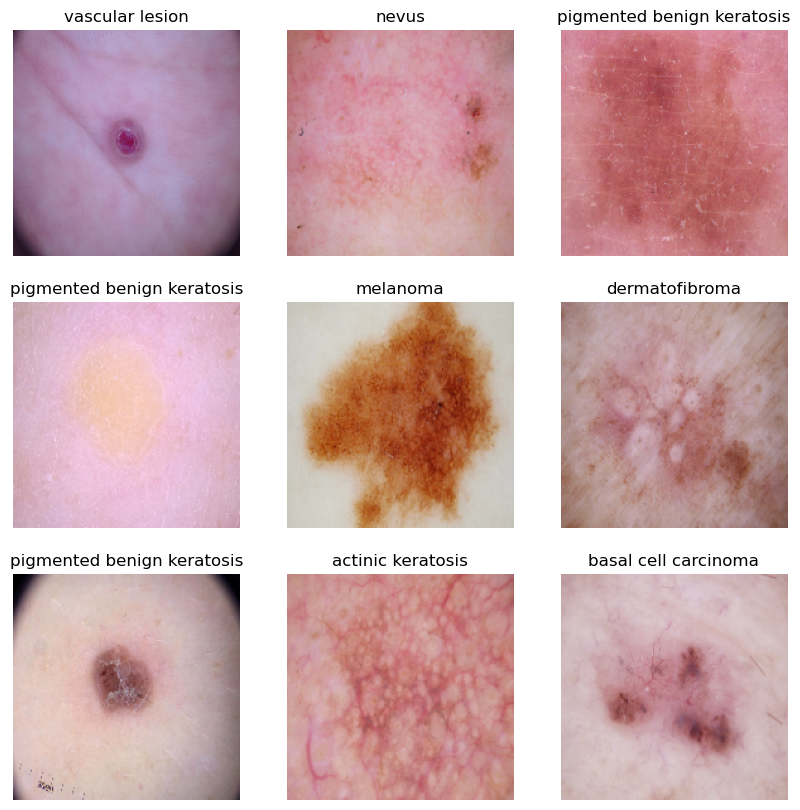

In [8]:
# visualize one instance of all the nine classes present in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##### The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

##### `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

##### `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create Model

In [10]:
# Define the CNN model
model = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with 512 units
    layers.Dense(512, activation='relu'),
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile Model

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      31,719,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,817,801 (121.38 MB)

 Trainable params: 31,817,801 (121.38 MB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.2116 - loss: 3.2045 - val_accuracy: 0.4072 - val_loss: 1.7750
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3458 - loss: 1.8273 - val_accuracy: 0.4385 - val_loss: 1.6549
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4628 - loss: 1.5447 - val_accuracy: 0.5011 - val_loss: 1.4544
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5199 - loss: 1.3718 - val_accuracy: 0.4989 - val_loss: 1.4272
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.5354 - loss: 1.2916 - val_accuracy: 0.5548 - val_loss: 1.3181
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5995 - loss: 1.1409 - val_accuracy: 0.5280 - val_loss: 1.3320
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6150 - loss: 1.0974 - val_accuracy: 0.5168 - val_loss: 1.4087
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6239 - loss: 1.0034 - val_accuracy: 0.5526 - val_loss:

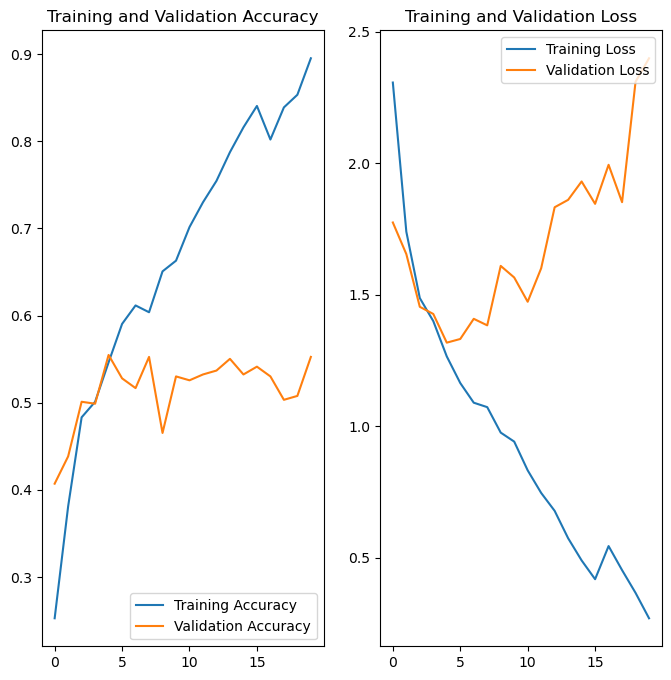

In [25]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations:

- Training accuracy improves steadily, but validation accuracy fluctuates and it indicating possible overfitting.

- Training loss decreases consistently, while validation loss increases after a point and its confirming overfitting.

- The model fits well to the training data but struggles to generalize to validation data.

In [15]:
# Balanced augmentation


# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the image by up to 20 degrees
    zoom_range=0.1,          # Random zoom up to 10%
    width_shift_range=0.1,   # Horizontal shift by 10%
    height_shift_range=0.1,  # Vertical shift by 10%
    horizontal_flip=True,    # Random horizontal flipping
    fill_mode='nearest',     # Fill strategy for new pixels after shift/rotation
    validation_split=0.2     # Split the dataset for validation
)

# No augmentation for validation data
val_datagen = ImageDataGenerator(
    validation_split=0.2  # Only splitting for validation, no augmentation
)

# Load training data with augmentation (subset='training')
train_ds_aug = datagen.flow_from_directory(
    data_dir_train,               # Path to training data directory
    target_size=(180, 180),   # Resize images to 180x180
    batch_size=32,            # Batch size
    class_mode='categorical', # Multi-class classification
    subset='training',        # Select the training data subset (80%)
    seed=123                  # For reproducibility
)

# Load validation data without augmentation (subset='validation')
val_ds = val_datagen.flow_from_directory(
    data_dir_train,               # Same directory, but without augmentation
    target_size=(180, 180),   # Resize images to 180x180
    batch_size=32,
    class_mode='categorical',
    subset='validation',     # Select the validation data subset (20%)
    seed=123
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


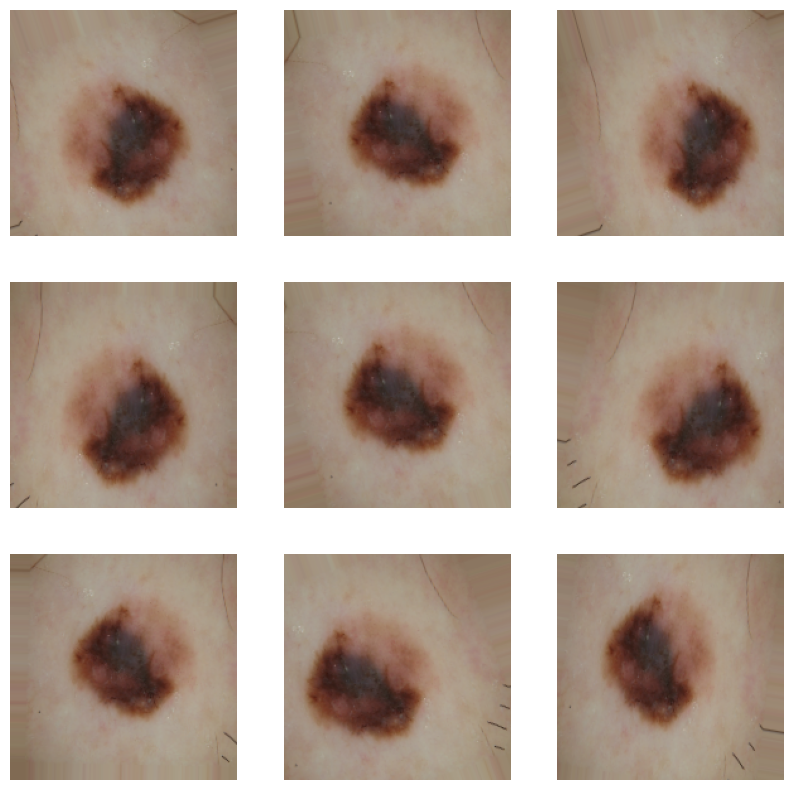

In [16]:
# Visualizing how augmentation strategy works for one instance of training image.

# Load one image from the training dataset
for images, _ in train_ds.take(1):  
    img = images[0].numpy().astype('uint8')  # Take the first image and convert it to numpy array

# Reshape the image for the generator 
img = np.expand_dims(img, 0)

# Generate augmented images from the single image
augmented_images = datagen.flow(img, batch_size=1)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 augmented images
    plt.subplot(3, 3, i + 1)
    aug_img = next(augmented_images)[0].astype('uint8')  # Generate next augmented image
    plt.imshow(aug_img)
    plt.axis('off')

plt.show()

#### Create model for Augmented data

In [17]:
# Define the CNN model with Dropout layers
model_aug = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First convolutional layer 
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D((2, 2)),
    
    
    # Second convolutional layer 
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
    layers.MaxPooling2D((2, 2)),
    
    
    
    # Third convolutional layer 
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  
    layers.MaxPooling2D((2, 2)),
   
   
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile model

In [19]:
model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

In [20]:
model_aug.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Model

In [21]:
history_aug = model_aug.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs
)

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.1864 - loss: 2.7400 - val_accuracy: 0.2275 - val_loss: 2.2392
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.3688 - loss: 1.9616 - val_accuracy: 0.4437 - val_loss: 1.9158
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4309 - loss: 1.7397 - val_accuracy: 0.4302 - val_loss: 1.9283
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4860 - loss: 1.5799 - val_accuracy: 0.3626 - val_loss: 2.0557
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.4935 - loss: 1.5956 - val_accuracy: 0.4302 - val_loss: 1.9092
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.4971 - loss: 1.5578 - val_accuracy: 0.4302 - val_loss: 1.8865
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5074 - loss: 1.5492 - val_accuracy: 0.4302 - val_loss: 2.1579
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5057 - loss: 1.5568 - val_accuracy: 0.4369 - v

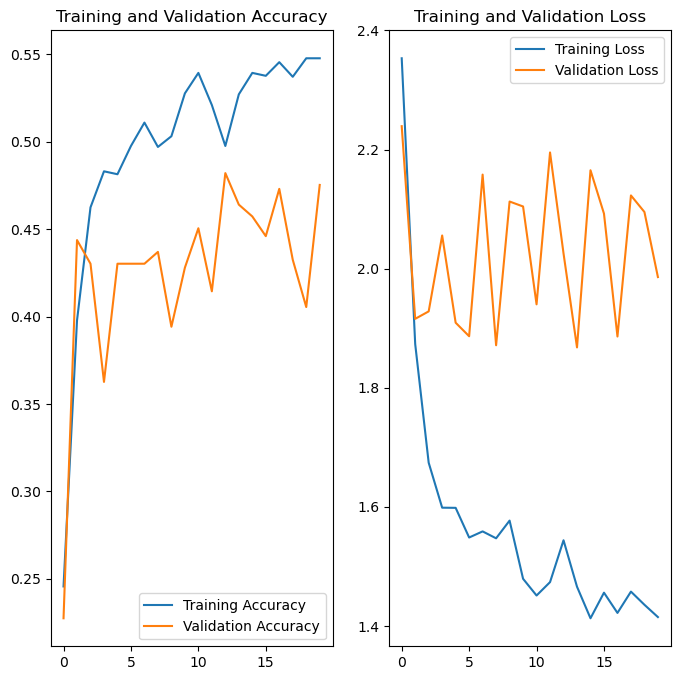

In [26]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:

- Training accuracy steadily increases, while validation accuracy fluctuates without significant improvement.
- Training loss decreases consistently, but validation loss remains high and unstable, further suggesting overfitting.
- The model fits the training data but struggles to perform consistently on validation data.

#### Finding the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
# Generate a list of all image file paths in the training data directory.
# This searches for all `.jpg` files within subdirectories of `data_dir_train`.
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 

# Extract the lesion labels by taking the name of the parent directory for each image.
# The parent directory represents the class or label of the image.
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

# Print the total number of labels (i.e., the total number of images in the dataset).
print(len(lesion_list))

2239


In [28]:
# Create a dictionary that maps each image file path to its corresponding lesion label.
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('C:\\Users\\Lenovo\\Documents\\DataSceince\\Melonama Detection Assignment\\Images\\Train\\actinic keratosis\\ISIC_0025780.jpg', 'actinic keratosis'), ('C:\\Users\\Lenovo\\Documents\\DataSceince\\Melonama Detection Assignment\\Images\\Train\\actinic keratosis\\ISIC_0025803.jpg', 'actinic keratosis')]


In [29]:
# Convert the dictionary of image paths and labels into a Pandas DataFrame.
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
1,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
2,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
3,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
4,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis


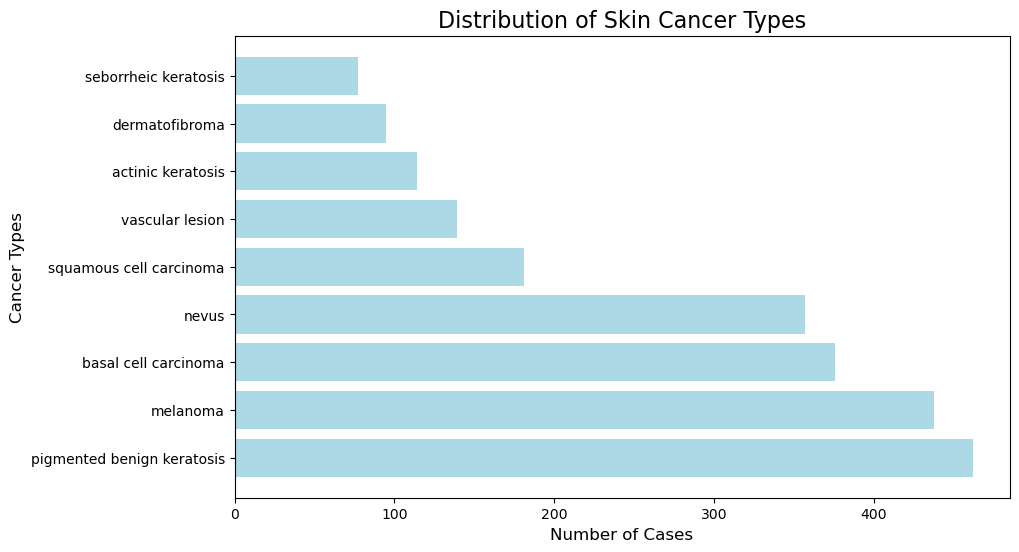

In [30]:
value_counts = original_df['Label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(value_counts.index, value_counts.values, color='lightblue')

# Add title and labels
plt.title('Distribution of Skin Cancer Types', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)

# Display the plot
plt.show()

#### Observations

 - Seborrheic keratosis class has the least number of samples.

 - Pigmented benign keratosis, melanoma, basal cell carcinoma and nevus classes dominate the data in terms proportionate number of samples.

#### Rectifying the class imbalance using Augmentor

##### To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [34]:
import Augmentor
path_to_training_dataset = str(data_dir_train) + '/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E440E9E810>: 100%|█| 500/500 [00:06<00:


Initialised with 376 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E374E9DFD0>: 100%|█| 500/500 [00:09<00:00, 54.32 Samples/


Initialised with 95 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E4410B4610>: 100%|█| 500/500 [00:09<00:


Initialised with 438 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1E440FC9510>: 100%|█| 500/500 [00:46<00:00, 10.84 Samples/


Initialised with 357 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x1E374F36810>: 100%|█| 500/500 [00:51<00:00,  9.75 Samples/


Initialised with 462 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E4410716D0>: 100%|█| 500/500 [00:09<00:00, 53.19 Samples/


Initialised with 77 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E440F44E10>: 100%|█| 500/500 [00:24<00:00, 20.27 Samples


Initialised with 181 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E43FFBA350>: 100%|█| 500/500 [00:08<00:00, 57.55 Samples/


Initialised with 139 image(s) found.
Output directory set to C:\Users\Lenovo\Documents\DataSceince\Melonama Detection Assignment\Images\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E440F6F890>: 100%|█| 500/500 [00:10<00:


In [35]:
# Let see augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['C:\\Users\\Lenovo\\Documents\\DataSceince\\Melonama Detection Assignment\\Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1ab8eaf2-61fc-4239-b5a1-93b939b33335.jpg',
 'C:\\Users\\Lenovo\\Documents\\DataSceince\\Melonama Detection Assignment\\Images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_45c97ca1-e4c5-49d6-87b2-077c111450dc.jpg']

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['actinic keratosis', 'actinic keratosis']

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

# Check the shape of the new DataFrame
new_df.shape

(6739, 2)

In [41]:
new_df.head()

,Path,Label
0,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
1,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
2,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
3,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis
4,C:\Users\Lenovo\Documents\DataSceince\Melonama...,actinic keratosis


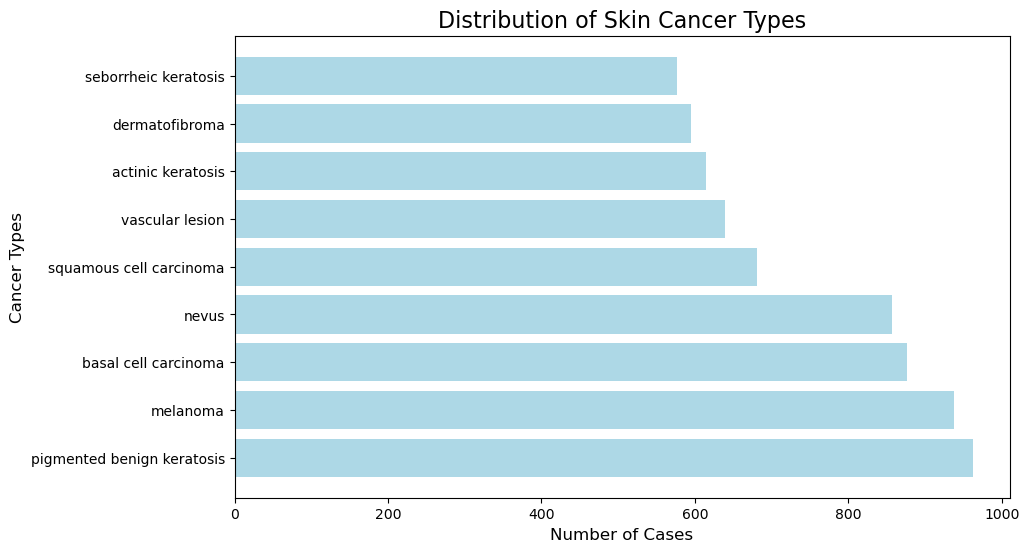

In [42]:
value_counts = new_df['Label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(value_counts.index, value_counts.values, color='lightblue')

# Add title and labels
plt.title('Distribution of Skin Cancer Types', fontsize=16)
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Cancer Types', fontsize=12)

# Display the plot
plt.show()

##### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
# Creating training and validation datasets
train_datagen = ImageDataGenerator(    
    validation_split=0.2  # Split the training data into train and validation sets
)

# Prepare training and validation datasets
train_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    seed = 123,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    seed = 123,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


#### Creating model (with Normalization)

In [47]:
model_bal = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3),),
    
    # First convolutional layer with Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
   
    
    # Second convolutional layer with Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    
    
    # Third convolutional layer with Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile model

In [48]:
model_bal.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

#### Train model

In [49]:
epochs = 30
history_bal = model_bal.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.3787 - loss: 3.9335 - val_accuracy: 0.1302 - val_loss: 5.4825
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5318 - loss: 2.7872 - val_accuracy: 0.1756 - val_loss: 3.6428
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.6121 - loss: 2.2427 - val_accuracy: 0.4881 - val_loss: 2.4436
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.6552 - loss: 2.0529 - val_accuracy: 0.4323 - val_loss: 2.9159
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7005 - loss: 2.1203 - val_accuracy: 0.5677 - val_loss: 2.5962
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7419 - loss: 2.0909 - val_accuracy: 0.1481 - val_loss: 6.9323
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7629 - loss: 2.3073 - val_accuracy: 0.3333 - val_loss: 3.8528
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.8065 - loss: 2.3498 - val_accu

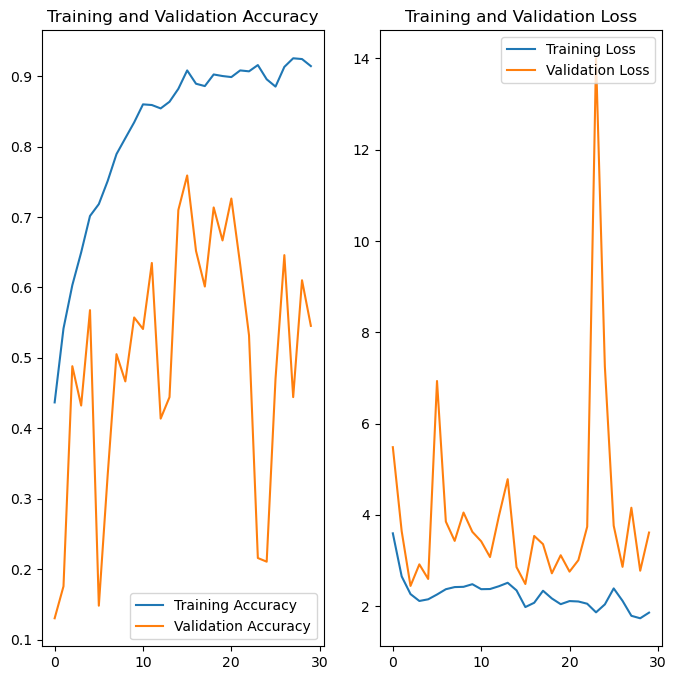

In [50]:
acc = history_bal.history['accuracy']
val_acc = history_bal.history['val_accuracy']

loss = history_bal.history['loss']
val_loss = history_bal.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations

- Training accuracy steadily increases and reaches high levels, but validation accuracy is highly unstable, indicating poor generalization.
- Training loss decreases steadily, while validation loss fluctuates widely, confirming instability and potential overfitting.

- After using model with batch normalization, there is large fluctuations in validation metrics suggesting instability and to stablilize and improve we will use regularization

In [51]:
train_datagen = ImageDataGenerator(    
    validation_split=0.2  # Split the training data into train and validation sets
)

# Prepare training and validation datasets
train_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


##### Creating Model with l2 regularizers

In [52]:
model_l2 = models.Sequential([
    
    # Rescaling layer to normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3),),
    
    # First convolutional layer with Dropout
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
   
    
    # Second convolutional layer with Dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    
    # Third convolutional layer with Dropout
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    
    
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    
    # Dense layer with Dropout
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout with 50% rate to prevent overfitting
    
    # Output layer for 9 classes with softmax activation
    layers.Dense(9, activation='softmax')
])

#### Compile model

In [54]:
# Set custom learning rate for the Adam optimizer
learning_rate = 0.0001

# Compile the model
model_l2.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [56]:
epochs = 50
history_l2 = model_l2.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.2064 - loss: 2.7969 - val_accuracy: 0.3765 - val_loss: 1.9880
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.3697 - loss: 1.9442 - val_accuracy: 0.4613 - val_loss: 1.7334
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.4447 - loss: 1.7302 - val_accuracy: 0.4740 - val_loss: 1.5918
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.4861 - loss: 1.6043 - val_accuracy: 0.5223 - val_loss: 1.4640
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.5397 - loss: 1.4901 - val_accuracy: 0.5513 - val_loss: 1.4530
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.5545 - loss: 1.4391 - val_accuracy: 0.5692 - val_loss: 1.3457
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.5970 - loss: 1.3513 - val_accuracy: 0.5818 - val_loss: 1.3156
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6053 - loss: 1.2881 - val_accu

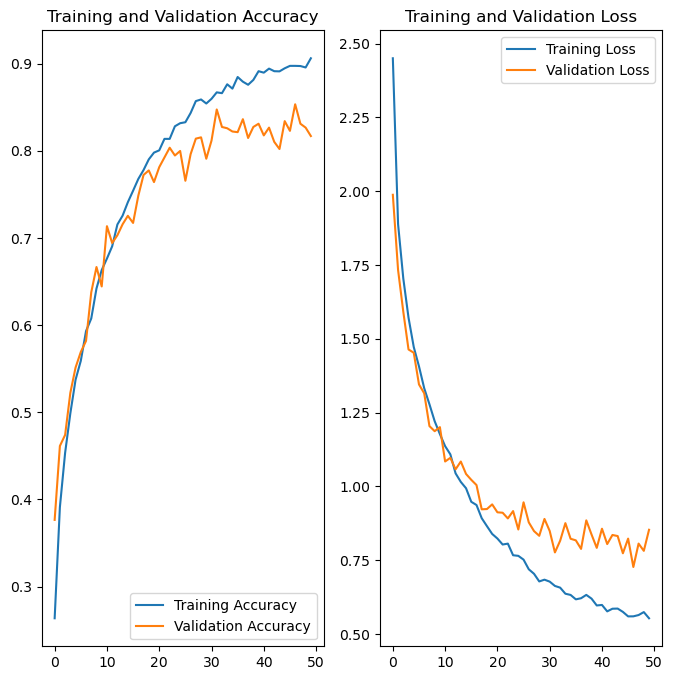

In [57]:
acc = history_l2.history['accuracy']
val_acc = history_l2.history['val_accuracy']

loss = history_l2.history['loss']
val_loss = history_l2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Observations

- The training and validation accuracy steadily increase.
- Both training and validation loss consistently decrease over time, showing the model's learning progress.

- The model performance is increased steadily on both training and validation data.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


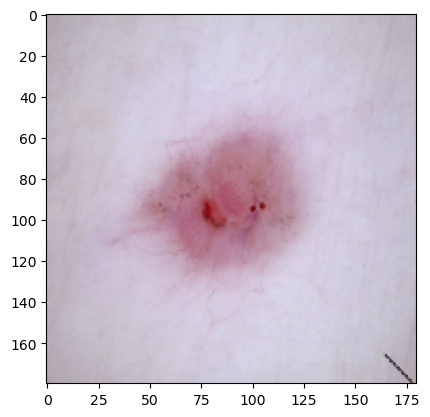

In [62]:
# Construct the path to a test image
test_image_path = os.path.join(data_dir_test, class_names[1], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[8], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[1])
print("Predicted Class: " + pred_class)